# Lazy computation

Abstracting out the array interface using `autoray` also allows tracing through
computations lazily. This is useful for a number of purposes, including:

1. Investigating the computational graph, including cost and memory usage, 
   of a calculation ahead of time.
2. Doing basic computational graph optimizations such as **constant folding**
   and **intermediate sharing**.
3. Extracting a flattened list of operations that can be compiled or 
   translated to other libraries.

This is implemented in a very lightweight fashion in `autoray` using the array 
backend found in [autoray.lazy](autoray.lazy).

---

As an illustration first let's define a simple autoray function:

In [1]:
%config InlineBackend.figure_formats = ['svg']

from autoray import do, shape


def modified_gram_schmidt(X):
    # n.b. performance-wise this particular function is *not*
    # a good candidate for a pure python implementation

    Q = []
    for j in range(0, shape(X)[0]):

        q = X[j, :]
        for i in range(0, j):
            rij = do('tensordot', do('conj', Q[i]), q, 1)
            q = q - rij * Q[i]

        rjj = do('linalg.norm', q, 2)
        Q.append(q / rjj)

    return do('stack', tuple(Q), axis=0)

This function automatically dispatches based on ``X``. Let's start with a
`torch` tensor:

In [2]:
# input array - can be anything autoray.do supports
x = do('random.normal', size=(6, 6), like='torch')
modified_gram_schmidt(x)

tensor([[-0.5805, -0.4512, -0.2807,  0.3313,  0.4838,  0.1920],
        [ 0.3426,  0.2975,  0.3121,  0.3296,  0.7331, -0.2251],
        [-0.3725,  0.1051,  0.3351, -0.7794,  0.3566,  0.0568],
        [ 0.6077, -0.3415, -0.4634, -0.3796,  0.3007,  0.2547],
        [-0.0159,  0.5119, -0.0306,  0.1317,  0.0139,  0.8481],
        [ 0.1933, -0.5641,  0.7042,  0.1128, -0.1033,  0.3538]])

If instead we wanted to run the function lazily, we first call 
[`lazy.array`](autoray.lazy.array) to wrap `x`:

In [3]:
from autoray import lazy

lx = lazy.array(x)
ly = modified_gram_schmidt(lx)
ly

<LazyArray(fn=stack, shape=(6, 6), backend='torch')>

[`LazyArray`](autoray.lazy.LazyArray) objects simply stores the following:

* The function to be called and backend it came from
* The `args` and `kwargs` to be passed to the function
* A tuple of which of these are themselves `LazyArray` objects, known as
  *'dependencies'*
* The shape of `fn(*args, **kwargs)` were it to be computed

If a lazy array is an input (as with `lx`), or has been materialized / 
computed, then it simply stores the result and shape of the computation, and 
has no reference to *how* it was computed. This means you should do any
inspection of the graph before performing computation.

## Inspection

For speed and simplicity, there is not an actual graph data structure, instead
the `LazyArray` objects simply track their dependencies (and not their 
'children'). However from this we can still traverse the nodes and extract an 
actual graph if so desired. Useful methods are:

* [`LazyArray.ascend`](autoray.lazy.ascend) - generate every unique node
  in the graph, yielding dependencies before their children (i.e. a topological
  sort). This is the computational order. Nodes are also sorted by their 
  *'depth'*, i.e. the longest distance to an input.

* [`LazyArray.descend`](autoray.lazy.descend) - generate every unique node
  in the graph, starting from the current node. Use this if order doesn't 
  matter.

```{hint}
Both these can be called as methods but also have top level function versions 
that also accept a sequence of `LazyArray` objects - i.e. multiple outputs.
```

You can also extract an actual graph using the following method:

- [`LazyArray.to_nx_digraph`](autoray.lazy.LazyArray.to_nx_digraph)


Some built in graph inspection methods are illustrated below:

In [4]:
# print the lazy computation graph
ly.show(max_lines=40)

   0 stack[6, 6]
   1 ├─truediv[6]
   2 │ ├─getitem[6]
   3 │ │ ╰─←[6, 6]
   4 │ ╰─linalg_norm[]
   5 │   ╰─ ... (getitem[6] from line 2)
   6 ├─truediv[6]
   7 │ ├─sub[6]
   8 │ │ ├─getitem[6]
   9 │ │ │ ╰─ ... (←[6, 6] from line 3)
  10 │ │ ╰─mul[6]
  11 │ │   ├─ ... (truediv[6] from line 1)
  12 │ │   ╰─tensordot[]
  13 │ │     ├─ ... (getitem[6] from line 8)
  14 │ │     ╰─conj[6]
  15 │ │       ╰─ ... (truediv[6] from line 1)
  16 │ ╰─linalg_norm[]
  17 │   ╰─ ... (sub[6] from line 7)
  18 ├─truediv[6]
  19 │ ├─sub[6]
  20 │ │ ├─sub[6]
  21 │ │ │ ├─getitem[6]
  22 │ │ │ │ ╰─ ... (←[6, 6] from line 3)
  23 │ │ │ ╰─mul[6]
  24 │ │ │   ├─ ... (truediv[6] from line 1)
  25 │ │ │   ╰─tensordot[]
  26 │ │ │     ├─ ... (getitem[6] from line 21)
  27 │ │ │     ╰─conj[6]
  28 │ │ │       ╰─ ... (truediv[6] from line 1)
  29 │ │ ╰─mul[6]
  30 │ │   ├─ ... (truediv[6] from line 6)
  31 │ │   ╰─tensordot[]
  32 │ │     ├─ ... (sub[6] from line 20)
  33 │ │     ╰─conj[6]
  34 │ │       ╰─ ... 

In [5]:
# how many times each function was called
ly.history_fn_frequencies()

{'stack': 1,
 'truediv': 6,
 'linalg_norm': 6,
 'sub': 15,
 'mul': 15,
 'getitem': 6,
 'None': 1,
 'tensordot': 15,
 'conj': 15}

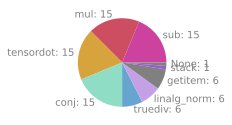

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [6]:
# the counts as a pie chart
ly.plot_history_stats(fn='count')

In [7]:
# the largest node encountered
ly.history_max_size()

36

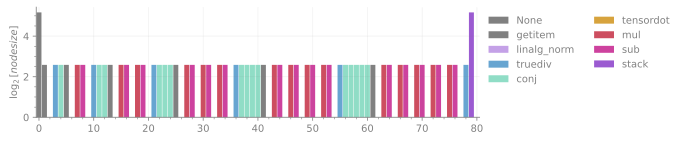

(<Figure size 2400x600 with 1 Axes>, <Axes: ylabel='$\\log_{2}[node size]$'>)

In [8]:
# the sizes of all nodes encountered, in log 2
ly.plot_history_functions(log=2)

In all the above you can also customize the function that is computed for each 
node, for instance to estimate FLOPs.

In [9]:
# the peak memory required for all intermediates when 
# traversing the graph in computational order
ly.history_peak_size()

72

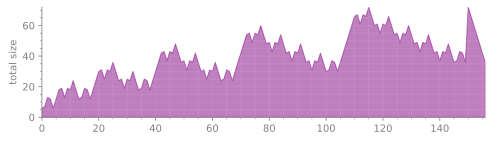

(<Figure size 2400x600 with 1 Axes>, <Axes: ylabel='total size'>)

In [10]:
# the total memory required for all intermediates when
# traversing the graph in computational order
ly.plot_history_size_footprint()

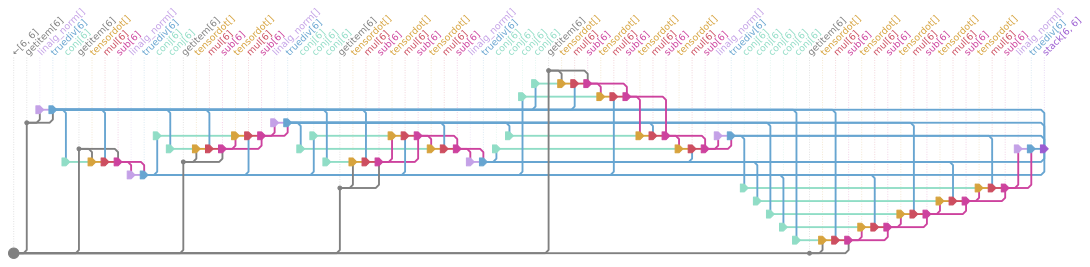

(<Figure size 1872.08x1872.08 with 1 Axes>, <Axes: >)

In [11]:
# plot the graph as circuit diagram
ly.plot_circuit()

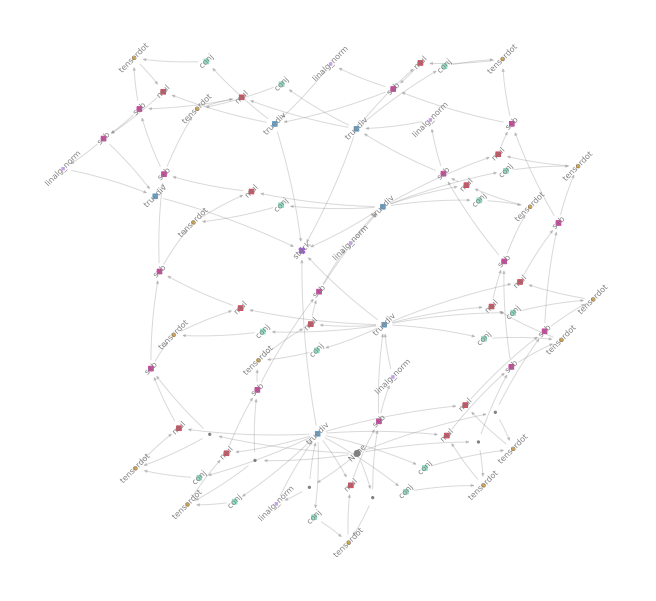

(<Figure size 900x900 with 1 Axes>, <Axes: >)

In [12]:
# plot the graph in using networkx or pygraphviz
ly.plot_graph(layout='sfdp')

## Computation

When you are ready to actually perform the computation, you can call 
[`LazyArray.compute`](autoray.lazy.LazyArray.compute) on output nodes:

In [13]:
ly.compute()

tensor([[-0.5805, -0.4512, -0.2807,  0.3313,  0.4838,  0.1920],
        [ 0.3426,  0.2975,  0.3121,  0.3296,  0.7331, -0.2251],
        [-0.3725,  0.1051,  0.3351, -0.7794,  0.3566,  0.0568],
        [ 0.6077, -0.3415, -0.4634, -0.3796,  0.3007,  0.2547],
        [-0.0159,  0.5119, -0.0306,  0.1317,  0.0139,  0.8481],
        [ 0.1933, -0.5641,  0.7042,  0.1128, -0.1033,  0.3538]])

```{note}
[`LazyArray`](autoray.lazy.LazyArray) objects clear references to their 
dependencies once computed and simply store the result and shape. This is to
aid garbage collection and reduce memory usage.
```

The computation is done non-recursively. You can compute multiple outputs at 
once with the function [`lazy.compute`](autoray.lazy.compute):

In [14]:
lazy.compute([ly[0], -ly[0]])

(tensor([-0.5805, -0.4512, -0.2807,  0.3313,  0.4838,  0.1920]),
 tensor([ 0.5805,  0.4512,  0.2807, -0.3313, -0.4838, -0.1920]))

### Sharing intermediates

A basic computational graph optimization that `autoray` can do is to 
automatically cache [`LazyArray`](autoray.lazy.LazyArray) objects that are
computed with the same inputs. This is achieved with the context manager:

* [`lazy.shared_intermediates`](autoray.lazy.shared_intermediates)

In [15]:
with lazy.shared_intermediates():
    ly_shared = modified_gram_schmidt(lx)

# reconstruct the non-shared lazy graph
ly = modified_gram_schmidt(lx)

In this case you can see a slight reduction in the number of unique nodes:

In [16]:
len(list(ly.descend())), len(list(ly_shared.descend()))

(80, 70)

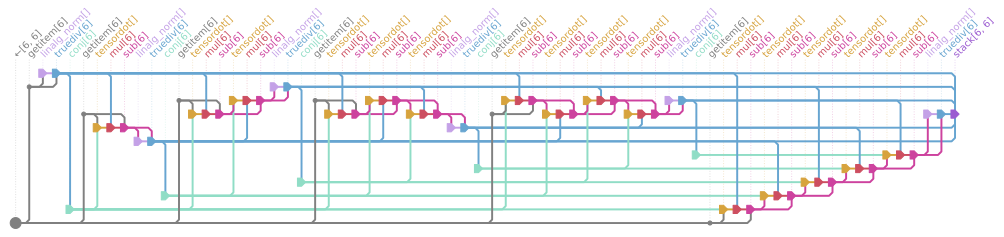

(<Figure size 1714.64x1714.64 with 1 Axes>, <Axes: >)

In [17]:
ly_shared.plot_circuit()

### `Function`, `Variable`, and constant folding

Sometimes you may want to think of certain input nodes as variables, which 
might change from call to call, and any other inputs as constants. One option
is to create 'empty' 
[`LazyArray`](autoray.lazy.LazyArray) instances with 
[`lazy.Variable`](autoray.lazy.Variable), which just 
takes a shape and optionally backend, and uses a placeholder for the data.

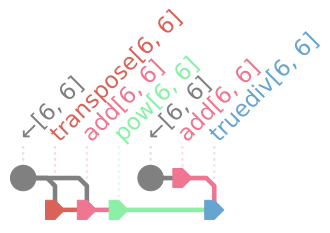

(<Figure size 400x400 with 1 Axes>, <Axes: >)

In [18]:
lx = lazy.Variable((6, 6), backend='numpy')

ly = lazy.array(do('random.normal', size=(6, 6), like='numpy'))
ly += ly.T
ly **= 2 

lz = ly / (lx + 3)

lz.plot_circuit()

If we tried to call `lz.compute()` now, we would get an error relating to
attempting to use the placeholder data, we would need to substitute it in 
first.

However we can compute all the nodes that don't depend on the variable like so:

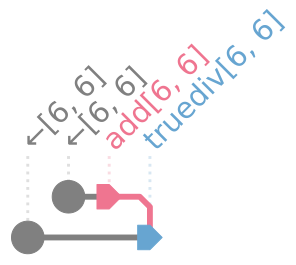

(<Figure size 292.402x292.402 with 1 Axes>, <Axes: >)

In [19]:
lz.compute_constants(variables=[lx])

# now all that remain is parts of the computational graph that depend on lx
lz.plot_circuit()

If one wants to extract the function that the computational graph represents, 
in order to call it repeatedly with different inputs, then one can create a 
[`lazy.Function`](autoray.lazy.Function):

In [20]:
f = lazy.Function(inputs=lx, outputs=lz)
f

<Function(array_like) -> array_like>

```{hint}
By default, [`lazy.Function`](autoray.lazy.Function) will compute constants, 
as we did above, this can be disabled by passing `fold_constants=False`.
```

In [21]:
# create a numpy array
x = do('random.normal', size=(6, 6), like='numpy')

# now we can call it on a raw numpy array
f(x)

array([[1.60841992e-04, 8.12123221e-01, 1.97831460e+00, 1.13263167e-01,
        2.33488356e-01, 4.08718533e-03],
       [2.18269736e-01, 1.04576049e+00, 5.29610184e-01, 6.86544110e-01,
        4.30559858e-03, 1.45473766e+00],
       [3.47257338e+00, 1.07335438e+00, 1.32390470e-01, 7.11823564e-01,
        1.11092912e-01, 2.23358234e+00],
       [1.87099522e-01, 5.45491213e-01, 7.87780835e-01, 1.07803626e+00,
        5.32992554e-03, 9.09088651e-01],
       [2.97641208e-01, 3.39287590e-03, 5.68403161e-02, 4.84043497e-03,
        9.40752758e-01, 2.27492826e+00],
       [2.94115949e-03, 1.52417836e+00, 1.55115629e+00, 6.83576849e-01,
        5.76864117e-01, 1.09412185e-03]])

```{note}
Such a function is created with the backend specific functions injected in, see
[the compilation](compilation) section and [`autojit`](autoray.autojit) for 
creating such functions just in time for the right backend.
```

You can view the function's source code using
[Function.print_source](autoray.lazy.Function.print_source), or extract it 
from [`LazyArray`](autoray.lazy.LazyArray) objects yourself with 
[lazy.get_source](autoray.lazy.get_source).

## Comparison to alternatives: 
 
The main difference to other approaches is that `autoray` is super simple and 
lightweight, and is not concerned with complex optimizations or modes of 
execution. 

As demonstrated below, the dispatch mechanism in `autoray` is compatible with
tensors objects from both these libraries, so it is not an either/or situation. 
The comparison is only with regard to when you might want to use lazy 
computational graph tracing.


### `dask`

There are many reasons to use [dask](https://dask.org/), but it incurs a pretty 
large overhead for big computational graphs with comparatively small 
operations. Calling and computing the ``modified_gram_schmidt`` function for a 
100x100 matrix (20,102 computational nodes) with ``dask.array`` takes ~1min 
whereas with ``lazy.array`` it takes ~0.2s:

In [ ]:
import dask.array as da

x = do('random.normal', size=(100, 100), like='numpy')

In [ ]:
%%time
dx = da.array(x)
dy = modified_gram_schmidt(dx)
y = dy.compute()

CPU times: user 58.5 s, sys: 315 ms, total: 58.8 s
Wall time: 58.2 s


In [ ]:
%%time
lx = lazy.array(x)
ly = modified_gram_schmidt(lx)
y = ly.compute()

CPU times: user 204 ms, sys: 12.1 ms, total: 216 ms
Wall time: 208 ms


Moreover `autoray.lazy` can also lazily wrap around more backends such
as `torch` due to the [automatic dispatch](automatic_dispatch) mechanism.

### `aesara`

[`aesara`](https://aesara.readthedocs.io) is another nice library, and the 
successor to [`theano`](https://github.com/Theano/Theano). It is much more 
heavyweight than `autoray` with a focus on optimizations, symbolic 
manipulations such as gradients, and compilation to 
specific targets (`jax`, `numba` or `C`). It also supports dynamic shapes, 
whereas `autoray` restricts itself to static shapes.

`aesara` is indeed quite compatible with `autoray`, but the fact that 
it often falls back to dynamic/unknown shapes occasionally makes things 
tricky.


In [15]:
import aesara
import aesara.tensor as at

# create equivalent of a Variable
ax = at.tensor("float64", (10, 10))

In [16]:
%%time
# construct the computational graph
ay = modified_gram_schmidt(ax)

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 174 ms


In [17]:
# aesara falls back to dynamic shapes quite often, which can be tricky
print(ay, shape(ay))

Join.0 (None, None)


In [26]:
# # if you want to view the graph, you could use pydotprint:
# aesara.printing.pydotprint(ay)

Actually compiling the graph can take quite a long time for anything but
quite small graphs (similarly to `jax`/XLA):

In [19]:
%%time
f = aesara.function([ax], ay)

CPU times: user 5min 53s, sys: 189 ms, total: 5min 54s
Wall time: 5min 54s


However, the function produced, should be heavily optimized, and ought to be 
much faster than a pure python function for computations not dominated by large
linear algebra operations.

In [25]:
x = do('random.normal', size=(10, 10), like='numpy')
f(x)

array([[ 0.08811928,  0.45177107, -0.23512127,  0.56826279, -0.10209893,
         0.04483325,  0.00321893, -0.06721217,  0.23305057,  0.58194387],
       [ 0.20286314, -0.16805831, -0.22599417,  0.12787872, -0.0876818 ,
        -0.34810252, -0.36127286, -0.46075707, -0.61894859,  0.09165501],
       [ 0.13412721,  0.36994813,  0.700074  , -0.06636773, -0.23315896,
        -0.44683645,  0.13946412, -0.26698148,  0.07190328, -0.02673288],
       [ 0.1407475 ,  0.29877271,  0.14226686, -0.02852857,  0.04154398,
         0.75386262,  0.07329936, -0.44735181, -0.25730248, -0.16773645],
       [ 0.04966494,  0.17005891, -0.26316584, -0.51207777,  0.319918  ,
        -0.1089547 , -0.302915  , -0.43376454,  0.48719139,  0.07516769],
       [ 0.02527629, -0.27882853,  0.49141276,  0.35693951,  0.63621879,
         0.07151982, -0.34254243, -0.019437  ,  0.0824143 ,  0.13538384],
       [ 0.76372311,  0.15424796, -0.13639341, -0.06633823,  0.40270286,
        -0.13394064,  0.31463354,  0.2651581 

Hopefully `aesara` will be another possible target for 
[`autoray.autojit`](autoray.autojit), eventually.